# Imports

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from datetime import datetime 

In [2]:
import sys
!{sys.executable} -m pip install adjustText
from adjustText import adjust_text

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7098 sha256=2de6d3a95830677df65d1b7060291c2c1062b57806561e2d93e38c5858a5d264
  Stored in directory: /zhome/48/e/160183/.cache/pip/wheels/06/b2/e0/b239bd2c0ff89b98c4f0c86a63e7059f38a8dfaf6df2641c63
Successfully built adjustText


In [10]:
df = pd.read_csv('https://gitlab.gbar.dtu.dk/s210172/ukraine-analytics/raw/master/data/articles/df_articles_march.csv')
df.drop(['Unnamed: 0', 'URL to image', 'URL'], axis = 1, inplace = True) 
df.head()
set(df.Country.unique())

{'de', 'es', 'fr', 'gb', 'it', nan, 'ru', 'us'}

In [11]:
df = df[df['Country'].isin(['us', 'gb'])]
df.head()
set(df.Country.unique())


{'gb', 'us'}

In [12]:
# Group articles of  news agencies together - create n documents (n=num of agencies)
df_grouped = df[df['Content'].notna()]
df_grouped = df_grouped.groupby(['News source'])['Content'].apply(lambda x: ','.join(x)).reset_index()

df_grouped

News source                                            Content
0                  ABC News  Though threatened by the Kremlin for decades, ...
1                  BBC News  A Ukrainian mother says her children "made pis...
2                 Bloomberg  Beginning of dialog window. Escape will cancel...
3          Business Insider  Ukrainian President Volodymyr Zelensky said Ru...
4                  CBS News  Watch CBS News\r\nCopyright ©2022 CBS Interact...
5                       CNN  New York (CNN)The maker of Stolichnaya vodka a...
6                  Fox News  Europe needs to wake up. The biggest nuclear p...
7               Independent  Ukraine has announced a cryptocurrency airdrop...
8                  NBC News  Of the many distortions manufactured by Russia...
9                   Reuters  LVIV, Ukraine, March 6 (Reuters) - Ukraine has...
10  The Wall Street Journal  CHISINAU, MoldovaSecretary of State Antony Bli...
11      The Washington Post  It cited a high risk of foreign-leased planes ...

# Doc2Vec

# Study

In [14]:
!pip install gensim
import gensim
import gensim.downloader as api

dataset = api.load("text8")
data = [d for d in dataset]

     |████████████████████████████████| 24.1 MB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 3.5 MB/s  eta 0:00:01
[=====================================-------------] 74.0% 23.4/31.6MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 31.6/31.6MB downloaded


## Example

In [69]:
#Import packages
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

## Exapmple document (list of sentences)
doc = ["I love data science",
        "I love coding in python",
        "I love building NLP tool",
        "This is a good phone",
        "This is a good TV",
        "This is a good laptop"]

# Tokenization of each document
tokenized_doc = []
for d in doc:
    tokenized_doc.append(word_tokenize(d.lower()))
tokenized_doc

[['i', 'love', 'data', 'science'],
 ['i', 'love', 'coding', 'in', 'python'],
 ['i', 'love', 'building', 'nlp', 'tool'],
 ['this', 'is', 'a', 'good', 'phone'],
 ['this', 'is', 'a', 'good', 'tv'],
 ['this', 'is', 'a', 'good', 'laptop']]

## Implementation #1

In [15]:
doc = df_grouped['Content'].tolist()
# Tokenization of each document
tokenized_doc = []
for d in doc:
    tokenized_doc.append(word_tokenize(d.lower()))
# tokenized_doc

NameError: name 'word_tokenize' is not defined

In [ ]:
# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
# tagged_data

In [18]:
!pwd
!cd ./apnews_dbow/doc2vec.bin
!pwd

/zhome/48/e/160183/sem2/aba/Project/notebooks/articles
/zhome/48/e/160183/sem2/aba/Project/notebooks/articles


In [21]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

## Train doc2vec model
# model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs = 100)
# Save trained doc2vec model
# model.save("test_doc2vec.model")
## Load saved doc2vec model
# model= Doc2Vec.load("../test_doc2vec.model")
model= Doc2Vec.load("./apnews_dbow/doc2vec.bin")
## Print model vocabulary
# model.wv.vocab
words = list(model.wv.index_to_key)
words

AttributeError: Can't get attribute 'DocvecsArray' on <module 'gensim.models.doc2vec' from '/zhome/48/e/160183/anaconda3/lib/python3.8/site-packages/gensim/models/doc2vec.py'>

In [76]:
news_agencies

['ABC News',
 'Bloomberg',
 'Business Insider',
 'CBS News',
 'CNN',
 'Fox News',
 'NBC News',
 'Reuters',
 'The Wall Street Journal',
 'The Washington Post']

C:\Users\Laura\AppData\Local\Temp/ipykernel_14024/1632405449.py:5: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors = [model.docvecs[i] for i in range(len(news_agencies))]


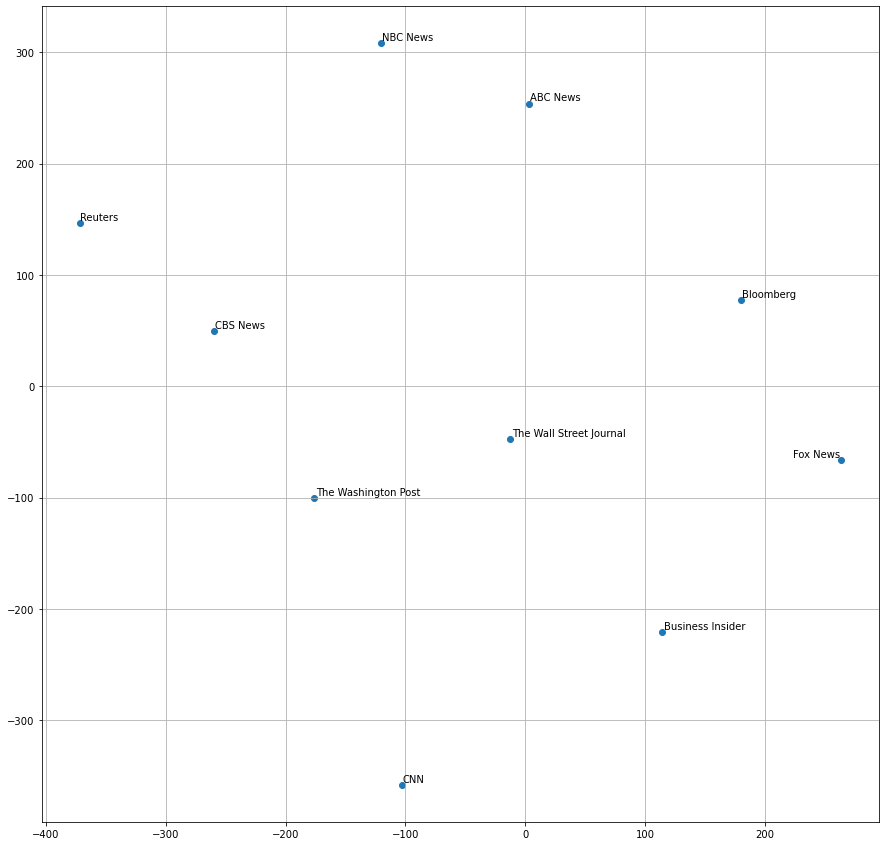

In [77]:
from adjustText import adjust_text
news_agencies = list(df_grouped['News source'].values)

# vectors= [embs_dict[word] for word in news_agencies]
vectors = [model.docvecs[i] for i in range(len(news_agencies))]
agencies_to_vec = dict(zip(news_agencies, vectors))

# tsne - t-distributed stochastic neighbouring  embedding
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
vectors_2d_tsne= tsne.fit_transform(vectors)

plt.figure(figsize=(15,15))

plt.scatter(vectors_2d_tsne.T[0], vectors_2d_tsne.T[1])

texts = [plt.text(vectors_2d_tsne.T[0][i], vectors_2d_tsne.T[1][i], news_agencies[i]) for i in range(len(news_agencies))]
adjust_text(texts)
            
plt.grid()
plt.show()

In [ ]:
# find most similar doc 
test_doc = word_tokenize("That is a good device".lower())
model.docvecs.most_similar(positive=[model.infer_vector(test_doc)],topn=5)

## Implementation #2

In [18]:
# Doc2vec algorithm (input is document, output= embedding vector representing each document).
# We can check both which are most similar and also most different
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vec_size, alpha=alpha,  min_alpha=0.00025, min_count=1, dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

TypeError: The corpus_iterable must be an iterable of lists of strings, got 20 instead